<h1> 5XWA0 Power System Analysis and Optimization</h1>
<h2> Assignment 4: Multi-period optimal power flow with energy storage </h2> <br>
<h3> Group number: 11</h3>
<h3> Student names: Filip Forro & N. K. Panda</h3>

<h4>INSTRUCTIONS</h4>

The first two code blocks are already filled-in for you. You do not need to make any changes there. 

Your code, according to the requirements of the assignment, needs to be completed in the third block. 

After that point, feel free to add as many blocks as you need (e.g., to solve different instances of the model, extract or plot results). Make sure that you sufficiently document your code. 

<b>IMPORTANT: The report or the notebook should demonstrate how you have achieved your results.</b>

In case you need to import additional packages (e.g., for plotting) it is advisable that you import them in the first block and make sure that it is the one that runs first.

In [1]:
from pyomo.environ import *
from pyomo.opt import SolverStatus, TerminationCondition
import pandas, numpy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
#This is a custom function that writes all the decision variables to an excel file.
from Helper_Functions.exportDecisionVariables import exportDecisionVariables

In [2]:
def readInputFile(filename):
    
    # This method loads all the data from the .xlsx file. You do not need to modify anything here.
    
    NetworkData = pandas.read_excel(filename, sheet_name= 'NetworkData', index_col=0)
    SystemDemand= pandas.read_excel(filename, sheet_name = 'SystemDemand', index_col= 0)
    PVGeneration = pandas.read_excel(filename, sheet_name='PVGeneration', index_col=0)
    WindGeneration = pandas.read_excel(filename, sheet_name='WindGeneration', index_col=0) 
    LoadData = pandas.read_excel(filename, sheet_name = 'Loads', index_col= 0)
    PVData = pandas.read_excel(filename, sheet_name='PVParks', index_col=0)
    WPData = pandas.read_excel(filename, sheet_name='WindParks', index_col=0)
    StorageData = pandas.read_excel(filename, sheet_name= 'StorageSystems', index_col=0)
    UnitData = pandas.read_excel(filename, sheet_name = 'Generators', index_col= 0)
    GeneratorStepSizeData = pandas.read_excel(filename, sheet_name = 'GeneratorStepSize', index_col= 0)
    GeneratorStepCostData = pandas.read_excel(filename, sheet_name = 'GeneratorStepCost', index_col= 0)
    
    # We could return multiple items but it is preferable to return a structure, in this case a dictionary 
    return {'NetworkData':NetworkData, 'SystemDemand':SystemDemand, 'PVGeneration':PVGeneration, 'WindGeneration':WindGeneration,
            'LoadData':LoadData, 'PVData':PVData, 'WPData':WPData,'StorageData':StorageData,'UnitData':UnitData,
            'GeneratorStepSizeData':GeneratorStepSizeData, 'GeneratorStepCostData':GeneratorStepCostData}

In [3]:
def optimizationModel(inputData, modelType):
    
    # This method receives as an input the Data (the dictionary returned by readInputFile) and returns an optimization model
    # according to the value of modelType argument. 
    # Be careful: there is not a solve statement in this function! This means you should solve the model that is returned
    # after the method has been called!
    
    #---------------------------------------------------------------------------------------------------------
    #Unpack the data from the dictionary
    #---------------------------------------------------------------------------------------------------------
    NetworkData = inputData['NetworkData']
    SystemDemand = inputData['SystemDemand']
    PVGeneration = inputData['PVGeneration']
    WindGeneration = inputData['WindGeneration']
    LoadData = inputData['LoadData']
    PVData = inputData['PVData']
    WPData = inputData['WPData']
    StorageData = inputData['StorageData']
    UnitData = inputData['UnitData']
    GeneratorStepSizeData = inputData['GeneratorStepSizeData']
    GeneratorStepCostData = inputData['GeneratorStepCostData']   
    
    #---------------------------------------------------------------------------------------------------------
    #Define the Model
    #---------------------------------------------------------------------------------------------------------
    
    model = ConcreteModel()
    
    #---------------------------------------------------------------------------------------------------------
    #Define Sets
    #---------------------------------------------------------------------------------------------------------
    
    model.T = Set(ordered = True, initialize = SystemDemand.index) #Set for time steps
    
    model.I = Set(ordered = True, initialize = UnitData.index) #Set for generators
    model.F = Set(ordered = True, initialize = GeneratorStepSizeData.columns) #Set for generator cost blocks

    model.S = Set(ordered = True, initialize = StorageData.index) #Set for storage

    model.J = Set(ordered = True, initialize = LoadData.index) #Set for loads

    model.L = Set(ordered=True, initialize=NetworkData.index)  # Set for lines
    Buses = list(set(list(NetworkData.FROM.unique()) + list(NetworkData.TO.unique())))  # extract buses from NetworkData
    model.N = Set(ordered=True, initialize=Buses) #Set for buses. Be careful when interpreting results. This is not a sorted list.

    model.K = Set(ordered=True, initialize=PVData.index) # Set for PV
    model.Q = Set(ordered=True, initialize=WPData.index) # Set for Wind Park
    
    #---------------------------------------------------------------------------------------------------------
    #Define Parameters
    #---------------------------------------------------------------------------------------------------------
    
    #Question I.1: Define the technical and economic parameters of the generators
        #The parameters that you have to define should be named: Pmin, Pmax, RU, RD, SUC, SDC, Pini, uini,C, B. 
        #IMPORTANT: you need to identify the correct indices! 
    model.Pmin = Param(model.I, within = NonNegativeReals, mutable=True)
    model.Pmax = Param(model.I, within = NonNegativeReals, mutable=True)
    model.RU = Param(model.I, within = NonNegativeReals, mutable=True)
    model.RD = Param(model.I, within = NonNegativeReals, mutable=True)
    model.SUC = Param(model.I, within = NonNegativeReals, mutable=True)
    model.SDC = Param(model.I, within = NonNegativeReals, mutable=True)
    model.Pini = Param(model.I, within = NonNegativeReals, mutable=True)
    model.uini = Param(model.I, within = Binary, mutable=True)
    model.C = Param(model.I, model.F, within = NonNegativeReals, mutable=True)
    model.B = Param(model.I, model.F, within = NonNegativeReals, mutable=True)

    #PV parks
    model.PV = Param(model.K, model.T, within=NonNegativeReals, mutable=True) #Production of PV system k
    
    #Wind parks
    model.W = Param(model.Q, model.T, within=NonNegativeReals, mutable=True) #Production of Wind Park q

    #Load
    model.D = Param(model.J, model.T, within=NonNegativeReals, mutable = True) #Consumption of load j

    #Energy storage system
    model.ESS_Pmax = Param(model.S, within=NonNegativeReals, mutable=True)
    model.ESS_SOEmax = Param(model.S, within=NonNegativeReals, mutable=True)
    model.ESS_SOEini = Param(model.S, within=NonNegativeReals, mutable=True)
    model.ESS_Eff = Param(model.S, within=NonNegativeReals, mutable=True)

    # Transmission lines
    model.X = Param(model.L, within=NonNegativeReals, mutable=True)
    model.P_line_max = Param(model.L, within=NonNegativeReals, mutable=True)

    # Power flow parameters
    model.Bmat = Param(model.L, model.N, within=Reals, mutable=True)
    
    #---------------------------------------------------------------------------------------------------------
    #Initialize Parameters
    #---------------------------------------------------------------------------------------------------------

    #Question I.2: Give values to the parameters of the generators
    for i in model.I:
        model.Pmin[i] = UnitData.loc[i,'Pmin']
        model.Pmax[i] = UnitData.loc[i,'Pmax']
        model.RU[i] = UnitData.loc[i,'RU']
        model.RD[i] = UnitData.loc[i,'RD']
        model.SUC[i] = UnitData.loc[i,'SUC']
        model.SDC[i] = UnitData.loc[i,'SDC']
        model.Pini[i] = UnitData.loc[i,'Pini']
        model.uini[i] = UnitData.loc[i,'uini']
        for col in GeneratorStepCostData.columns:
            model.C[i,col] = GeneratorStepCostData.loc[i,col]
            model.B[i,col] = GeneratorStepSizeData.loc[i,col]
        
    #Question I.2: Allocate the total system demand to buses
    for j in model.J:
        for t in model.T:
            #print(j)
            #print(LoadData[LoadData['Location']==d]['Percentage'].item())
            #model.D[d,t] = SystemDemand.loc[t,'SystemDemand']*(LoadData[LoadData['Location']==d]['Percentage'].item())
            model.D[j,t] = SystemDemand.loc[t,'SystemDemand']*LoadData.loc[j,'Percentage']
            #print(SystemDemand.loc[t,'SystemDemand'])
            #print(LoadData.loc[j,'Percentage'])
            #print(model.D[j,t])
            
    #Give values to ESS parameters
    for s in model.S:
        model.ESS_Pmax[s] = StorageData.loc[s,'Power']
        model.ESS_SOEmax[s] = StorageData.loc[s,'Energy']
        model.ESS_SOEini[s] = StorageData.loc[s,'SOEini']
        model.ESS_Eff[s] = StorageData.loc[s,'Eff']

    # Give values to line parameters
    for l in model.L:
        model.X[l] = NetworkData.loc[l, 'X']
        model.P_line_max[l] = NetworkData.loc[l, 'Capacity']

    # Construct B- matrix
    for l in model.L:
        for n in model.N:
            if NetworkData.loc[l, 'FROM'] == n:
                model.Bmat[l, n] = 1 / model.X[l]
            elif NetworkData.loc[l, 'TO'] == n:
                model.Bmat[l, n] = - 1 / model.X[l]
            else:
                model.Bmat[l, n] = 0
    
    #Allocate the total PV generation to buses
    for k in model.K:
        for t in model.T:
            model.PV[k,t] = PVGeneration.loc[t, 'PVGeneration']*PVData.loc[k, 'Percentage']
            
    #Allocate the total Wind generation to buses
    for q in model.Q:
        for t in model.T:
            model.W[q,t] = WindGeneration.loc[t, 'WindGeneration']*WPData.loc[q, 'Percentage']        
    

    #---------------------------------------------------------------------------------------------------------
    #Define the Decision Variables
    #---------------------------------------------------------------------------------------------------------
    
    #Generators
    model.P = Var(model.I, model.T, within=NonNegativeReals)
    model.b = Var(model.I, model.F, model.T, within=NonNegativeReals)
    model.u = Var(model.I, model.T, within=Binary)
    model.CSU = Var(model.I, model.T, within=NonNegativeReals)
    model.CSD = Var(model.I, model.T, within=NonNegativeReals)
    
    #Network 
    model.Flow = Var(model.L, model.T, within=Reals) # Flow through transmission line
    model.theta = Var(model.N, model.T, within=Reals) # Bus angle
    
    #Question I.3: Define the decision variables related to energy storage systems
        #The variables that you have to define should be named: SOE, Pch, Pdis, u_ess 
        #IMPORTANT: you need to identify the correct indices and the domain of the variables! 
    #ESS
    model.SOE = Var(model.S, model.T, within=NonNegativeReals)
    model.Pch = Var(model.S, model.T, within=NonNegativeReals)
    model.Pdis = Var(model.S, model.T, within=NonNegativeReals)
    model.u_ess = Var(model.S, model.T, within=Binary)

    #---------------------------------------------------------------------------------------------------------
    #Define Constraints
    #---------------------------------------------------------------------------------------------------------
    # Question I.4: Complete the definition of constraints RampDownConstraint(), ShutDownCost(),ESS_SOEupdate(), Balance()
    
    def ObjectiveCost(model):   #Eq. (1)
        return sum(sum(sum(model.C[i,f]*model.b[i,f,t] for f in model.F) + model.CSU[i,t] + model.CSD[i,t] for i in model.I) for t in model.T)

    def PowerDecomposition1(model, i, t):  #Eq. (2)
        return model.P[i,t] == sum(model.b[i,f,t] for f in model.F)

    def PowerDecomposition2(model, i, f, t):  #Eq. (3)
        return model.b[i,f,t] <= model.B[i,f]

    def PowerMin(model, i , t): #Eq. (4)
        return model.P[i,t] >= model.Pmin[i]* model.u[i,t]

    def PowerMax(model, i, t): #Eq. (4)
        return model.P[i,t] <= model.Pmax[i]* model.u[i,t]

    def RampUpConstraint(model, i, t): #Eq. (5) and Eq. (6) 

        if model.T.ord(t) == 1:
            return model.P[i,t] - model.Pini[i] <= 60*model.RU[i]

        if model.T.ord(t) > 1: #model.T.prev(t) gives us t-1!
            return model.P[i,t] - model.P[i,model.T.prev(t)] <= 60*model.RU[i]

    def RampDownConstraint(model, i, t):  #Eq. (7) and Eq. (8)
        
        if model.T.ord(t) == 1:
            return model.Pini[i] - model.P[i,t] <= 60*model.RD[i]
        
        if model.T.ord(t) > 1:
            return model.P[i,model.T.prev(t)] - model.P[i,t] <= 60*model.RD[i]

    def StartUpCost(model, i, t): #Eq. (9) and Eq. (10)
        if model.T.ord(t) == 1:
            return model.CSU[i, t] >= model.SUC[i] * (model.u[i, t] - model.uini[i])

        if model.T.ord(t) > 1:
            return model.CSU[i, t] >= model.SUC[i] * (model.u[i, t] - model.u[i, model.T.prev(t)])

    def ShutDownCost(model, i, t): #Eq. (11) and Eq. (12)
        if model.T.ord(t) == 1:
            return model.CSD[i,t] >= model.SDC[i] * (model.uini[i] - model.u[i,t])
        if model.T.ord(t) > 1:
            return model.CSD[i,t] >= model.SDC[i] * (model.u[i,model.T.prev(t)] - model.u[i,t])


    def ESS_SOEupdate(model, s, t): #Eq. (13) and Eq. (14)

        if model.T.ord(t) == 1:
            return model.SOE[s,t] == model.ESS_SOEini[s] + model.ESS_Eff[s] * model.Pch[s,t] - model.Pdis[s,t]/model.ESS_Eff[s]

        if model.T.ord(t) > 1:
            return model.SOE[s,t] == model.SOE[s,model.T.prev(t)] + model.ESS_Eff[s] * model.Pch[s,t] - model.Pdis[s,t]/model.ESS_Eff[s]
    print(model.T.ord(t))    
    def ESS_SOElimit(model, s, t): #Eq. (15)
        return model.SOE[s,t] <= model.ESS_SOEmax[s]
    
    def ESS_Charging(model, s, t): #Eq. (16)
        return model.Pch[s,t] <= model.ESS_Pmax[s] * model.u_ess[s,t]

    def ESS_Discharging(model, s, t): #Eq. (16)
        return model.Pdis[s, t] <= model.ESS_Pmax[s] * (1-model.u_ess[s, t])

    def angle_ini_rule(model, t): #Eq. (18)
        return model.theta['Bus1', t] == 0

    def flow_limit_rule1(model, l, t): #Eq. (19)
        return -model.P_line_max[l] <= model.Flow[l,t]
    
    def flow_limit_rule2(model, l, t): #Eq. (19)
        return model.Flow[l,t] <= model.P_line_max[l]

    def line_flow_rule(model, l, n1, n2 ,t): #Eq. (20)
        if (n1 == NetworkData.loc[l, 'FROM']) and (n2 == NetworkData.loc[l, 'TO']):
            return model.Flow[l, t] == model.Bmat[l, n1] * (model.theta[n1, t] - model.theta[n2, t])
        else:
            return Constraint.Skip

    def pf_rule(model, n, t): #Eq. (21)
        return \
            sum(model.PV[k,t] for k in model.K if n==PVData.loc[k,'Location'])+\
            sum(model.W[q,t] for q in model.Q if n==WPData.loc[q,'Location'])+\
            sum(model.P[i, t] for i in model.I if n == UnitData.loc[i, 'Location']) + sum(model.Pdis[s, t] for s in model.S if n == StorageData.loc[s, 'Location'])+ sum(model.Flow[l, t] for l in model.L if n == NetworkData.loc[l, 'TO']) \
            == sum(model.D[j, t] for j in model.J if n == LoadData.loc[j, 'Location']) + sum(model.Pch[s, t] for s in model.S if n == StorageData.loc[s, 'Location']) + sum(model.Flow[l, t] for l in model.L if n == NetworkData.loc[l, 'FROM'])

    def balance(model, t): #Eq. (21) alternative according to Assignment 3, Question VI.
        return \
            sum(model.PV[k,t] for k in model.K)+\
            sum(model.W[q,t] for q in model.Q)+\
            sum(model.P[i,t] for i in model.I) + sum(model.Pdis[s,t] for s in model.S) \
            == sum(model.D[j,t] for j in model.J) + sum(model.Pch[s,t] for s in model.S)

    #---------------------------------------------------------------------------------------------------------
    #Add Constraints to the Model
    #---------------------------------------------------------------------------------------------------------
    
    #There are constraints that are common to all the 4 Cases
    model.ObjCost = Objective(rule=ObjectiveCost)
    model.ConPowerDecomposition1 = Constraint(model.I, model.T, rule=PowerDecomposition1)
    model.ConPowerDecomposition2 = Constraint(model.I, model.F, model.T, rule=PowerDecomposition2)
    model.ConPowerMin = Constraint(model.I, model.T, rule=PowerMin)
    model.ConPowerMax = Constraint(model.I, model.T, rule=PowerMax)
    model.ConSUC = Constraint(model.I, model.T, rule=StartUpCost)
    model.ConSDC = Constraint(model.I, model.T, rule=ShutDownCost)
    model.ConSOEUpdate = Constraint(model.S, model.T, rule=ESS_SOEupdate)
    model.ConCharging = Constraint(model.S, model.T, rule=ESS_Charging)
    model.ConDischarging = Constraint(model.S, model.T, rule=ESS_Discharging)
    model.ConSOElimit = Constraint(model.S, model.T, rule=ESS_SOElimit)
    
    #There are constraints specific to the case you are solving
    
    # Question I.4: Complete the conditions in order to add only the constraints that are relevant to the 4 Cases (Assignment 4, Question II.1)
    
    # NO network constarints/NO ramping constraints/NO transmission line limits
    if  modelType == 'Case1':
        model.Bal = Constraint(model.T, rule=balance)
        
    # YES network constraints/YES generator ramping contraints/YES transmission line limits
    elif  modelType == 'Case2':
        #generator ramping contraints           
        model.ConRampUP = Constraint(model.I, model.T, rule=RampUpConstraint)
        model.ConRampDWN = Constraint(model.I, model.T, rule=RampDownConstraint)
                   
        #transmission line limits
        model.flowlim1 = Constraint(model.L, model.T, rule = flow_limit_rule1)
        model.flowlim2 = Constraint(model.L, model.T, rule = flow_limit_rule2)
        
        #network constraints
        model.angleini = Constraint(model.T, rule = angle_ini_rule)
        model.lfrule = Constraint(model.L,model.N,model.N,model.T,rule=line_flow_rule)
        model.pfrule = Constraint(model.N,model.T, rule = pf_rule)

    # YES network constraints/YES generator ramping contraints/NO transmission line limits
    elif  modelType == 'Case3':
        #generator ramping contraints
        model.ConRampUP = Constraint(model.I, model.T, rule=RampUpConstraint)
        model.ConRampDWN = Constraint(model.I, model.T, rule=RampDownConstraint)
        
        #network constraints           
        model.angleini = Constraint(model.T, rule = angle_ini_rule)
        model.lfrule = Constraint(model.L,model.N,model.N,model.T,rule=line_flow_rule)
        model.pfrule = Constraint(model.N,model.T, rule = pf_rule)
    else:
        print('This is not a valid model type!')
        
    return model

<h1>Test file</h1>

In [4]:
filename = 'Assignment3_ValidationSystem.xlsx'
data = readInputFile(filename)
data['LoadData']









,Location,Percentage
Load1,Bus2,0.6
Load2,Bus4,0.4


# Run the test case and export data to confirm correct implementation

# Test Case 1

In [8]:
model = optimizationModel(data, 'Case1')
opt=SolverFactory('gurobi')
opt.options["MIPGap"] = 0.0
results=opt.solve(model)
#print(results)

print(model.ObjCost().round(3))
print(model.T.ord(t))


exportDecisionVariables(model, 'TestExportCase1.xlsx')









6
20117.4


NameError: name 't' is not defined

# Test Case 2

In [78]:
model = optimizationModel(data, 'Case2')
results=opt.solve(model)
#print(results)

print(model.ObjCost().round(3))
exportDecisionVariables(model, 'TestExportCase2.xlsx')

33244.94


# Test Case 3

In [79]:
model = optimizationModel(data, 'Case3')
results=opt.solve(model)
#print(results)

print(model.ObjCost().round(3))
exportDecisionVariables(model, 'TestExportCase3.xlsx')

32052.94


<h2>Part II -- Basic simulations</h2>

<h3> Question II.1 </h3>

In [80]:
filename = 'Input_Files\Assignment3_InputData.xlsx'
data = readInputFile(filename)
# SET RES TO 0 FOR THE FIRST TASK
data['PVGeneration'].loc[:] = 0 
data['WindGeneration'].loc[:] = 0  
data['StorageData']['Power'].loc[:] = 0

In [81]:
#A - Report and compare the total operating cost of the system in the following cases. 
model1 = optimizationModel(data,'Case1')
results1 = opt.solve(model1)
print(model1.ObjCost().round(3))

model2 = optimizationModel(data,'Case2')
results2 = opt.solve(model2)
print(model2.ObjCost().round(3))

model3 = optimizationModel(data,'Case3')
results3 = opt.solve(model3)
print(model3.ObjCost().round(3))

2655566.701
3406743.352
2675324.913


In [82]:
results_df = pandas.DataFrame(index=data['UnitData'].index, columns=['Type', 'Total Power [MW]', 'Total Energy [MWd]', 'Total Cost [Euro/day]', 'Daily Commitment Cost [Euro]'], dtype=float)
#B - For each generator type (per type code) compute and comment on: 
for i in model1.I:
    results_df.loc[i, 'Type'] = data['UnitData'].loc[i,'Type']
    results_df.loc[i, 'Total Power [MW]'] = sum(model1.P[i, t].value for t in model1.T)
    # the total daily energy generation
    results_df.loc[i, 'Total Energy [MWd]'] = results_df.loc[i, 'Total Power [MW]']
    # the total daily energy costs 
    results_df.loc[i, 'Total Cost [Euro/day]'] = sum((sum(model1.C[i,f].value*model1.b[i,f,t1].value for f in model1.F)) for t1 in model1.T)
     # the total daily commitment costs (i.e., start-up and shut-down costs) 
    results_df.loc[i, 'Daily Commitment Cost [Euro]'] = sum(model1.CSU[i, t2].value for t2 in model1.T) + sum(model1.CSD[i, t3].value for t3 in model1.T)
grouped = results_df.groupby('Type')
grouped['Total Power [MW]','Total Energy [MWd]','Total Cost [Euro/day]','Daily Commitment Cost [Euro]'].agg([np.sum])

,Total Power [MW],Total Energy [MWd],Total Cost [Euro/day],Daily Commitment Cost [Euro]
,sum,sum,sum,sum
Type,,,,
U100,2792.6,2792.6,4.795346e+05,15432.0
U12,0.0,0.0,0.000000e+00,751.5
U155,14880.0,14880.0,3.107926e+05,11470.0
U197,6175.4,6175.4,1.076367e+06,20156.5
U20,0.0,0.0,0.000000e+00,47.0
U350,8318.4,8318.4,1.783953e+05,0.0
U400,19200.0,19200.0,3.964301e+05,0.0
U50,7200.0,7200.0,0.000000e+00,0.0


In [99]:
results_df = pandas.DataFrame(index=data['UnitData'].index, columns=['Type', 'Total Power [MW]', 'Total Energy [MWd]', 'Total Cost [Euro/day]', 'Daily Commitment Cost [Euro]'], dtype=float)
#B - For each generator type (per type code) compute and comment on: 
for i in model2.I:
    results_df.loc[i, 'Type'] = data['UnitData'].loc[i,'Type']
    results_df.loc[i, 'Total Power [MW]'] = sum(model2.P[i, t].value for t in model2.T)
    # the total daily energy generation
    results_df.loc[i, 'Total Energy [MWd]'] = results_df.loc[i, 'Total Power [MW]']
    # the total daily energy costs 
    results_df.loc[i, 'Total Cost [Euro/day]'] = sum((sum(model2.C[i,f].value*model2.b[i,f,t1].value for f in model2.F)) for t1 in model2.T)
     # the total daily commitment costs (i.e., start-up and shut-down costs) 
    results_df.loc[i, 'Daily Commitment Cost [Euro]'] = sum(model2.CSU[i, t2].value for t2 in model2.T) + sum(model2.CSD[i, t3].value for t3 in model2.T)
grouped = results_df.groupby('Type')
grouped['Total Power [MW]','Total Energy [MWd]','Total Cost [Euro/day]','Daily Commitment Cost [Euro]'].agg([np.sum])

,Total Power [MW],Total Energy [MWd],Total Cost [Euro/day],Daily Commitment Cost [Euro]
,sum,sum,sum,sum
Type,,,,
U100,5337.249446,5337.249446,9.473797e+05,7716.0
U12,0.000000,0.000000,0.000000e+00,751.5
U155,14562.000000,14562.000000,3.037703e+05,11470.0
U197,8300.872048,8300.872048,1.453849e+06,11518.0
U20,63.200000,63.200000,1.472320e+04,188.0
U350,8361.000000,8361.000000,1.793961e+05,0.0
U400,13780.164306,13780.164306,2.823655e+05,0.0
U50,7200.000000,7200.000000,0.000000e+00,0.0


In [84]:
results_df = pandas.DataFrame(index=data['UnitData'].index, columns=['Type', 'Total Power [MW]', 'Total Energy [MWd]', 'Total Cost [Euro/day]', 'Daily Commitment Cost [Euro]'], dtype=float)
#B - For each generator type (per type code) compute and comment on: 
for i in model3.I:
    results_df.loc[i, 'Type'] = data['UnitData'].loc[i,'Type']
    results_df.loc[i, 'Total Power [MW]'] = sum(model3.P[i, t].value for t in model3.T)
    # the total daily energy generation
    results_df.loc[i, 'Total Energy [MWd]'] = results_df.loc[i, 'Total Power [MW]']
    # the total daily energy costs 
    results_df.loc[i, 'Total Cost [Euro/day]'] = sum((sum(model3.C[i,f].value*model3.b[i,f,t1].value for f in model3.F)) for t1 in model3.T)
     # the total daily commitment costs (i.e., start-up and shut-down costs) 
    results_df.loc[i, 'Daily Commitment Cost [Euro]'] = sum(model3.CSU[i, t2].value for t2 in model3.T) + sum(model3.CSD[i, t3].value for t3 in model3.T)
grouped = results_df.groupby('Type')
grouped['Total Power [MW]','Total Energy [MWd]','Total Cost [Euro/day]','Daily Commitment Cost [Euro]'].agg([np.sum])

,Total Power [MW],Total Energy [MWd],Total Cost [Euro/day],Daily Commitment Cost [Euro]
,sum,sum,sum,sum
Type,,,,
U100,2842.6,2842.6,4.892187e+05,15432.0
U12,29.0,29.0,6.323321e+03,751.5
U155,14810.0,14810.0,3.092225e+05,11470.0
U197,6189.4,6189.4,1.078875e+06,20156.5
U20,16.0,16.0,3.728715e+03,47.0
U350,8279.4,8279.4,1.774790e+05,0.0
U400,19200.0,19200.0,3.964301e+05,0.0
U50,7200.0,7200.0,0.000000e+00,0.0


<h3>Question II.2</h3>

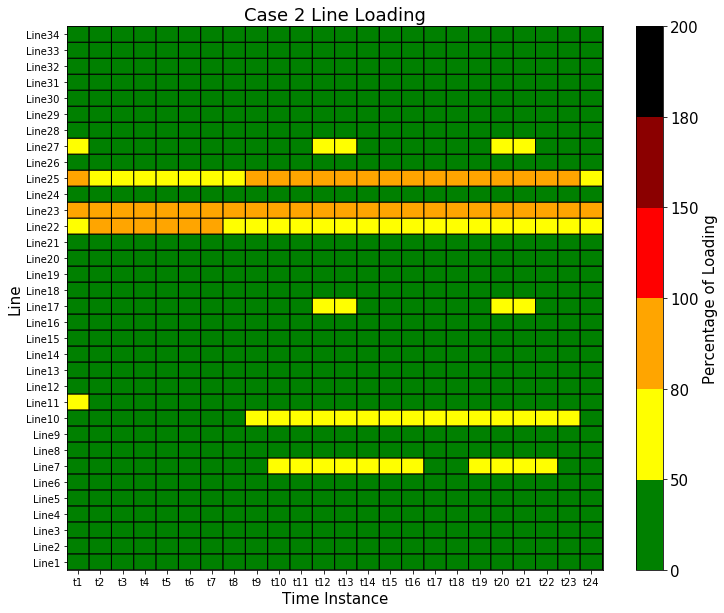

In [85]:
# Visualization of Loading of transmission lines for Case 2 and 3
# visualize 0-50%/50-80%/80-100%/100+
loading_case2 = pandas.DataFrame(index=data['NetworkData'].index,columns=model2.T)
for l in model2.L:
    for t in model2.T:
        loading_case2.loc[l,t] = abs(model2.Flow[l,t].value/model2.P_line_max[l].value)*100

plt.figure(figsize=(12,10))
cmap, norm = mcolors.from_levels_and_colors([0, 50, 80, 100.01, 150, 180,200], ['green', 'yellow', 'orange','red', 'darkred','black'])
plt.pcolor(loading_case2, cmap=cmap, norm=norm, edgecolors='k', linewidths=1)
plt.yticks(np.arange(0.5, len(loading_case2.index), 1), loading_case2.index)
plt.xticks(np.arange(0.5, len(loading_case2.columns), 1), loading_case2.columns)
plt.title("Case 2 Line Loading",fontsize=18)
plt.xlabel("Time Instance",fontsize=15)
cb = plt.colorbar()
cb.set_label("Percentage of Loading",fontsize=15)
plt.ylabel("Line",fontsize=15)
cb.ax.tick_params(labelsize=15)
plt.savefig("out_case2.png")
plt.show()

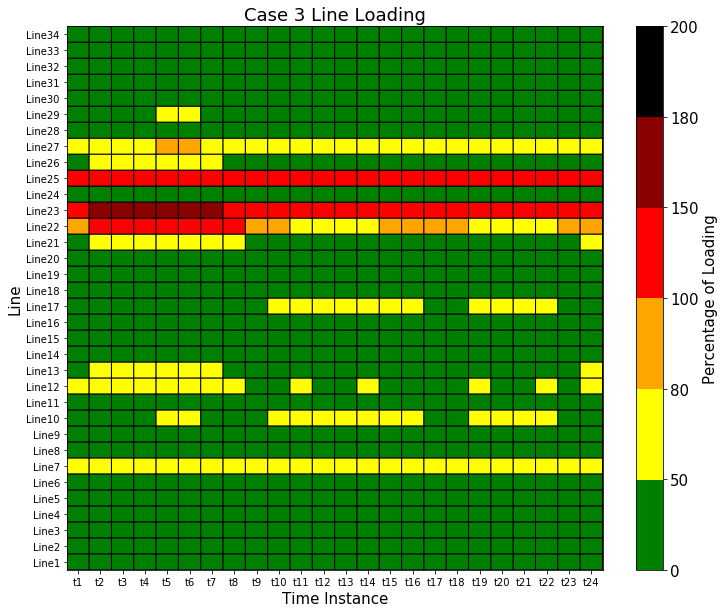

In [86]:
# Visualization of Loading of transmission lines for Case 2 and 3
# visualize 0-50%/50-80%/80-100%/100+
loading_case3 = pandas.DataFrame(index=data['NetworkData'].index,columns=model3.T)
for l in model3.L:
    for t in model3.T:
        loading_case3.loc[l,t] = abs(model3.Flow[l,t].value/model3.P_line_max[l].value)*100

plt.figure(figsize=(12,10))
plt.pcolor(loading_case3, cmap=cmap, norm=norm, edgecolors='k', linewidths=1)
plt.yticks(np.arange(0.5, len(loading_case3.index), 1), loading_case3.index)
plt.xticks(np.arange(0.5, len(loading_case3.columns), 1), loading_case3.columns)
plt.title("Case 3 Line Loading",fontsize=18)
plt.xlabel("Time Instance",fontsize=15)
cb = plt.colorbar()
cb.set_label("Percentage of Loading",fontsize=15)
plt.ylabel("Line",fontsize=15)
cb.ax.tick_params(labelsize=15)
plt.savefig("out_case3.png")
plt.show()

<h2>Part III --The effect of renewable generation and the ESS</h2>

In [87]:
# Data1 without Wind Generation (PV PLUS STORAGE)
data1 = readInputFile(filename)
data1['WindGeneration'].loc[:] = 0  
# Data2 for case 2 with no PV Generation (WIND PLUS STORAGE)
data2 = readInputFile(filename)
data2['PVGeneration'].loc[:] = 0 

<h3>Question III.1 </h3>

In [88]:
#solar case 3
modelC3_1 = optimizationModel(data1,'Case3')
resultsC3_1 = opt.solve(modelC3_1)
#wind case 3
modelC3_2 = optimizationModel(data2,'Case3')
resultsC3_2 = opt.solve(modelC3_2)
#solar case 2
modelC2_1 = optimizationModel(data1,'Case2')
resultsC2_1 = opt.solve(modelC2_1)
#wind case 3
modelC2_2 = optimizationModel(data2,'Case2')
resultsC2_2 = opt.solve(modelC2_2)

Section III task A for both scenarios

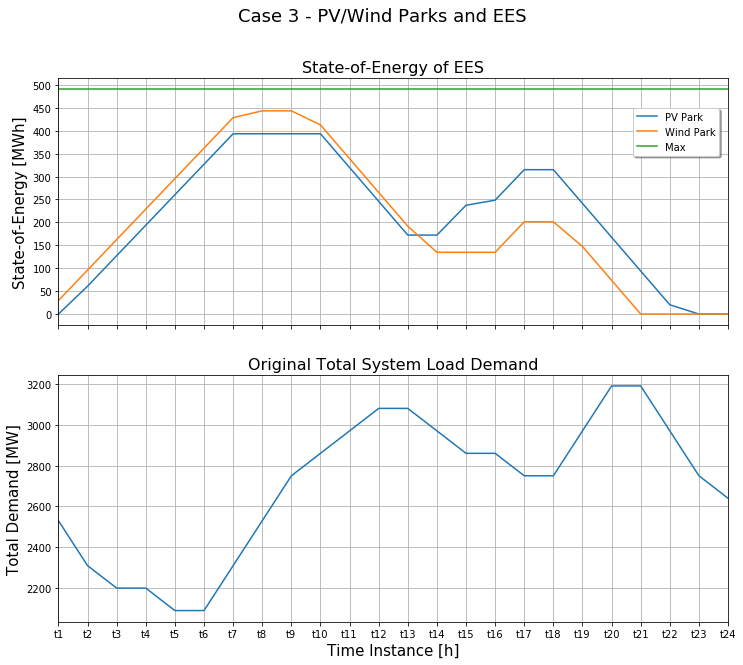

In [89]:
original_total_demand = pandas.DataFrame(columns=model3.T)
for t in model3.T:
    original_total_demand.loc['Total Demand',t] = sum(model3.D[j,t].value for j in model3.J)
StateOfEnergyPVC3 = pandas.DataFrame(columns=model3.T)
for t in modelC3_1.T:
    StateOfEnergyPVC3.loc['SoE',t] = sum(modelC3_1.SOE[s,t].value for s in modelC3_1.S)
StateOfEnergyWC3 = pandas.DataFrame(columns=model3.T)
for t in modelC3_2.T:
    StateOfEnergyWC3.loc['SoE',t] = sum(modelC3_2.SOE[s,t].value for s in modelC3_2.S)
    
fig, ax = plt.subplots(2,1,figsize=(12,10),sharex=True)
fig.suptitle('Case 3 - PV/Wind Parks and EES',fontsize=18)
ax[0].set_title('State-of-Energy of EES',fontsize=16)
ax[1].set_title('Original Total System Load Demand',fontsize=16)
ax[0].plot(modelC3_2.T, StateOfEnergyPVC3.loc['SoE',:])
ax[0].plot(modelC3_2.T, StateOfEnergyWC3.loc['SoE',:])
ax[0].plot(modelC3_2.T, np.ones(len(modelC2_2.T))*490)
ax[0].set_yticks(np.arange(0, 550, 50))
ax[0].legend(('PV Park', 'Wind Park','Max'), bbox_to_anchor=(0.85, 0.9), loc=2, shadow=True)
ax[0].set_ylabel("State-of-Energy [MWh]",fontsize=15)
ax[1].plot(modelC3_1.T, original_total_demand.loc['Total Demand',:])
ax[1].set_xlabel("Time Instance [h]",fontsize=15)
ax[1].set_ylabel("Total Demand [MW]",fontsize=15)
ax[0].grid(True)
ax[1].set_xlim(['t1','t24'])
ax[1].grid(True)
plt.savefig("PVorWind_plus_EES_A.png")
plt.show()

In [90]:
#original_total_demand.to_csv('Case3.csv')
new1 = original_total_demand.T
new1['EES_PV'] = StateOfEnergyPVC3.T
new1['EES_Wind'] = StateOfEnergyWC3.T
new1.to_csv('Case3.csv')

Section III task B for both scenarios

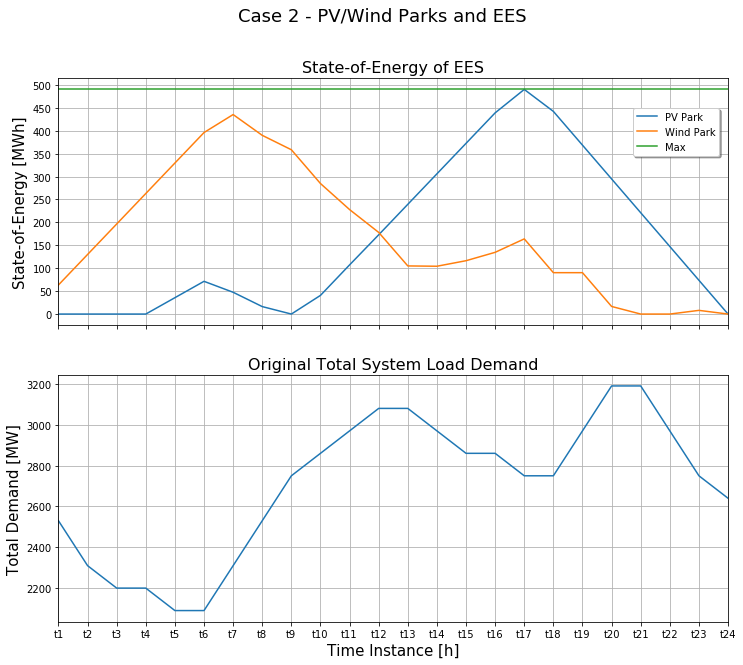

In [91]:
original_total_demand = pandas.DataFrame(columns=model2.T)
for t in model2.T:
    original_total_demand.loc['Total Demand',t] = sum(model2.D[j,t].value for j in model2.J)
StateOfEnergyPVC2 = pandas.DataFrame(columns=model2.T)
for t in modelC2_1.T:
    StateOfEnergyPVC2.loc['SoE',t] = sum(modelC2_1.SOE[s,t].value for s in modelC2_1.S)
StateOfEnergyWC2 = pandas.DataFrame(columns=model2.T)
for t in modelC2_2.T:
    StateOfEnergyWC2.loc['SoE',t] = sum(modelC2_2.SOE[s,t].value for s in modelC2_2.S)
    
fig, ax = plt.subplots(2,1,figsize=(12,10),sharex=True)
fig.suptitle('Case 2 - PV/Wind Parks and EES',fontsize=18)
ax[0].set_title('State-of-Energy of EES',fontsize=16)
ax[1].set_title('Original Total System Load Demand',fontsize=16)
ax[0].plot(modelC2_2.T, StateOfEnergyPVC2.loc['SoE',:])
ax[0].plot(modelC2_2.T, StateOfEnergyWC2.loc['SoE',:])
ax[0].plot(modelC2_2.T, np.ones(len(modelC2_2.T))*490)
ax[0].set_yticks(np.arange(0, 550, 50))
ax[0].legend(('PV Park', 'Wind Park','Max'), bbox_to_anchor=(0.85, 0.9), loc=2, shadow=True)
ax[0].set_ylabel("State-of-Energy [MWh]",fontsize=15)
ax[1].plot(modelC2_1.T, original_total_demand.loc['Total Demand',:])
ax[1].set_xlabel("Time Instance [h]",fontsize=15)
ax[1].set_ylabel("Total Demand [MW]",fontsize=15)
ax[0].grid(True)
ax[1].set_xlim(['t1','t24'])
ax[1].grid(True)
plt.savefig("PVorWind_plus_EES_B.png")
plt.show()

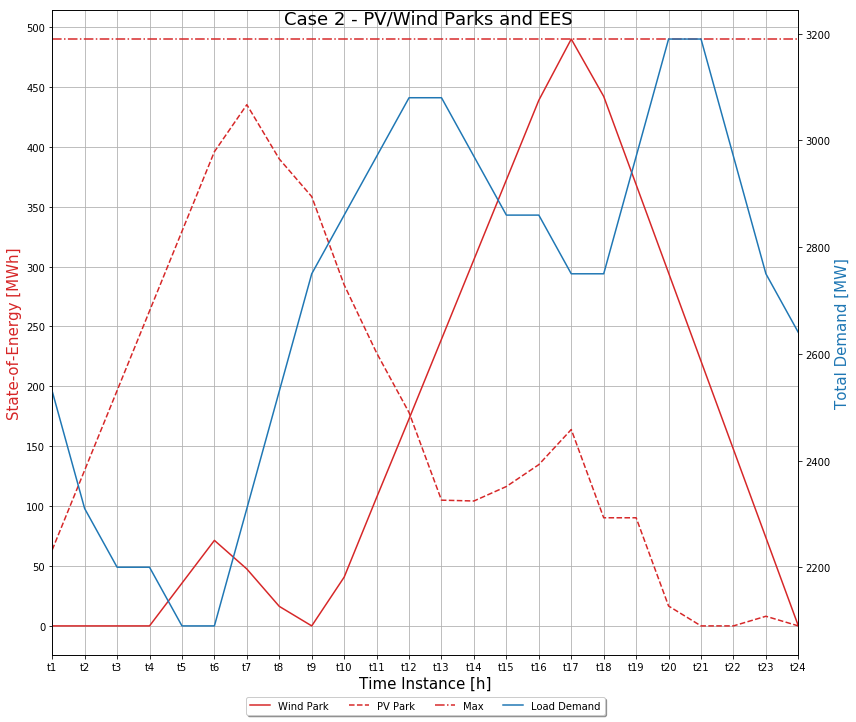

In [92]:
fig, ax = plt.subplots(figsize=(12,10))
fig.suptitle('Case 2 - PV/Wind Parks and EES',fontsize=18)
color = 'tab:red'
lns1 = ax.plot(modelC2_2.T, StateOfEnergyPVC2.loc['SoE',:],color=color,label='Wind Park')
lns2 = ax.plot(modelC2_2.T, StateOfEnergyWC2.loc['SoE',:],'--',color=color,label='PV Park')
lns3 = ax.plot(modelC2_2.T, np.ones(len(modelC2_2.T))*490,'-.',color=color,label='Max')
ax.set_yticks(np.arange(0, 550, 50))
ax.set_ylabel("State-of-Energy [MWh]",fontsize=15,color = 'tab:red')
ax.set_xlabel("Time Instance [h]",fontsize=15)
ax.grid(True)
ax.set_xlim(['t1','t24'])
ax2 = ax.twinx()
color = 'tab:blue'
ax2.set_ylabel("Total Demand [MW]",fontsize=15,color=color)
lns4 = ax2.plot(modelC2_1.T, original_total_demand.loc['Total Demand',:],color=color,label='Load Demand')

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs,bbox_to_anchor=(0.5, -0.1), loc=8, shadow=True,ncol=4)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("Try.png")
plt.show()

In [93]:
new2 = original_total_demand.T
new2['EES_PV'] = StateOfEnergyPVC2.T
new2['EES_Wind'] = StateOfEnergyWC2.T
new2.to_csv('Case2.csv')

<h3>Question III.2</h3>

In 7 hours we have same rating as before (70 MW) <br/> 
In 1 hour the power rating of energy storage is 490 MW <br/>
The way this data are collected can be compared to the reply on Canvas: <br/>
<img src="table.png" style="height:250px">

In [94]:
#what is already calculated
case2_no_res = model2.ObjCost().round(3)
case3_no_res = model3.ObjCost().round(3)
PV_plus_EES_7h_case2 = modelC2_1.ObjCost().round(3)
PV_plus_EES_7h_case3 = modelC3_1.ObjCost().round(3)
Wind_plus_EES_7h_case2 = modelC2_2.ObjCost().round(3)
Wind_plus_EES_7h_case3 = modelC3_2.ObjCost().round(3)

In [95]:
def select_data(data, PV, WIND, EES, Disch):
    if PV == 0:
        data['PVGeneration'].loc[:] = 0 
    if WIND == 0:
        data['WindGeneration'].loc[:] = 0  
    if EES == 0:
        data['StorageData']['Power'].loc[:] = 0
    if Disch == 1:
        data['StorageData']['Power'].loc[:] = 490
    return data

In [96]:
import copy
data = readInputFile(filename)
#PV No ESS Case 2
dat = select_data(data, 1, 0, 0, 7)
model = optimizationModel(dat,'Case2')
results = opt.solve(model)
PV_no_ees_case2 = model.ObjCost().round(3)
#PV No ESS Case 3
model = optimizationModel(dat,'Case3')
results = opt.solve(model)
PV_no_ees_case3 = model.ObjCost().round(3)
#Wind No ESS Case 2
data = readInputFile(filename)
dat = select_data(data, 0, 1, 0, 7)
model = optimizationModel(dat,'Case2')
results = opt.solve(model)
Wind_no_ees_case2 = model.ObjCost().round(3)
#Wind No ESS Case 3
model = optimizationModel(dat,'Case3')
results = opt.solve(model)
Wind_no_ees_case3 = model.ObjCost().round(3)
#PV +ESS 1h discharge case 2
data = readInputFile(filename)
dat = select_data(data, 1, 0, 1, 1)
model = optimizationModel(dat,'Case2')
results = opt.solve(model)
PV_plus_EES_1h_case2 = model.ObjCost().round(3)
#PV +ESS 1h discharge case 3
model = optimizationModel(dat,'Case3')
results = opt.solve(model)
PV_plus_EES_1h_case3 = model.ObjCost().round(3)
#Wind +ESS 1h discharge case 2
data = readInputFile(filename)
dat = select_data(data, 0, 1, 1, 1)
model = optimizationModel(dat,'Case2')
results = opt.solve(model)
Wind_plus_EES_1h_case2 = model.ObjCost().round(3)
#Wind +ESS 1h discharge case 3
model = optimizationModel(dat,'Case3')
results = opt.solve(model)
Wind_plus_EES_1h_case3 = model.ObjCost().round(3)

In [97]:
# Duplicate the table described on Canvas with results

results_IIIa = pandas.DataFrame(index=['Case 2', 'Case 3'], columns=['No renewables','PV No ESS','PV + ESS 7h discharge','PV + ESS 1h discharge'], dtype=float)
results_IIIa.index.name = 'System Costs'
results_IIIa.loc[:,'No renewables'] = [case2_no_res, case3_no_res]
results_IIIa.loc[:,'PV No ESS'] = [PV_no_ees_case2, PV_no_ees_case3]
results_IIIa.loc[:,'PV + ESS 7h discharge'] = [PV_plus_EES_7h_case2, PV_plus_EES_7h_case3]
results_IIIa.loc[:,'PV + ESS 1h discharge'] = [PV_plus_EES_1h_case2, PV_plus_EES_1h_case3]
results_IIIa

,No renewables,PV No ESS,PV + ESS 7h discharge,PV + ESS 1h discharge
System Costs,,,,
Case 2,3406743.352,2714416.944,2628670.513,2621953.933
Case 3,2675324.913,2225935.791,2155231.547,2135396.990


In [98]:
results_IIIb = pandas.DataFrame(index=['Case 2', 'Case 3'], columns=['No renewables','WP No ESS','WP + ESS 7h discharge','WP + ESS 1h discharge'], dtype=float)
results_IIIb.index.name = 'System Costs'
results_IIIb.loc[:,'No renewables'] = [case2_no_res, case3_no_res]
results_IIIb.loc[:,'WP No ESS'] = [Wind_no_ees_case2, Wind_no_ees_case3]
results_IIIb.loc[:,'WP + ESS 7h discharge'] = [Wind_plus_EES_7h_case2, Wind_plus_EES_7h_case3]
results_IIIb.loc[:,'WP + ESS 1h discharge'] = [Wind_plus_EES_1h_case2, Wind_plus_EES_1h_case3]
results_IIIb


,No renewables,WP No ESS,WP + ESS 7h discharge,WP + ESS 1h discharge
System Costs,,,,
Case 2,3406743.352,2251186.642,2159255.453,2140127.551
Case 3,2675324.913,2084572.144,2006599.888,1991522.549
